In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'malicious-urls-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1486586%2F2456026%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240416%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240416T074413Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dddd827949f16510cb1fd49d440ba6151955f80a83aee8d5e47de625e74063297828c3b861a7f23a2a8e186c14baf2602fddfef0a03da4d77daf0c7be49546037009632ff3fdd2c2886ede0162a6657b6c66dd0f620d4f354031483e6d7b590c044e656d4ecf437f9a82251c7f95b713b807939cc194dd9983c95c91f85986042df426c5e451c69ff21f0f50828d49f7be8085c735fd08d75747298de6586d84cb2163a164d15d718cf86f3ab9ae74fe987c717c0b7d8ee840ac5c0e2e616b78a8c32f45242c12e2fb9fe7a53292ea4ae468d5782629852a91a6ca9a4a49a1ca23a0f20812880a670f9322f9d1403bf5648e0efab7a4259dd22efabea1cda5c88'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 17748901 bytes downloaded
Downloaded and uncompressed: malicious-urls-dataset
Data source import complete.


**Importing Dataset**

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/malicious-urls-dataset/malicious_phish.csv


**Downloading Essential Extensions**

In [4]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.0 MB/s eta 0:00:00


In [5]:
!pip install colorama

**Importing Libraries**

In [6]:
import re
import string
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from urllib.parse import urlparse
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from colorama import Fore
from datetime import datetime
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from wordcloud import WordCloud
from gensim.models import Word2Vec
import hashlib
#import whois
import warnings

warnings.filterwarnings("ignore")

In [7]:
!pip install tldextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 3.5 MB/s eta 0:00:00


In [8]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.9 MB/s eta 0:00:00


In [9]:
import tldextract
from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError

**Save Dataset in df**

In [10]:
df = pd.read_csv('/kaggle/input/malicious-urls-dataset/malicious_phish.csv')

In [11]:
df.head(5)     # show the first 5 rows of dataset

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


**Pre-Processing**

In [13]:
df.info()    # tell about the type, features, null values, and total rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [14]:
df.describe(include='all')   # tell about features of columns

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [15]:
df.isnull().sum()   # tell about null values in each feature

url     0
type    0
dtype: int64

**Data Visualization**

In [ ]:
count = df['type'].value_counts()
colors = [
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D'
]
fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))])
fig.update_layout(
    xaxis_title='Types',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)
fig.update_xaxes(tickfont=dict(color='white'))
fig.update_yaxes(tickfont=dict(color='white'))
fig.show()

# for count of values

In [16]:
df['url'] = df['url'].replace('www.', '', regex=True)   # replace "www" with "" in URLs
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [17]:
df["type"].value_counts()   # value counts for each type of URL

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

In [18]:
df["url_type"] = df["type"].replace({
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
});

# replace with numbers for processing

In [19]:
df.head(5)    # show the first 5 rows of dataset

,url,type,url_type
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


**Feature Extraction**

In [20]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)

In [21]:
df['url_len'] = df['url'].apply(lambda x: get_url_length(str(x)))

In [22]:
df.head(7)  # show the first 7 rows of dataset

,url,type,url_type,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,111
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45


In [23]:
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

    # calculating pri-domains

In [24]:
df['pri_domain'] = df['url'].apply(lambda x: extract_pri_domain(x))

In [25]:
df.head(7)   # show the first 7 rows of dataset

,url,type,url_type,url_len,pri_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,111,buzzfil.net
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,espn.go.com


In [26]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

def count_special_chars(url):
    special_chars = set(string.punctuation)
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

    # calculating count of alphabets, numbers and special characters in URL

In [27]:
df['letters_count']        = df['url'].apply(lambda x: count_letters(x))
df['digits_count']         = df['url'].apply(lambda x: count_digits(x))
df['special_chars_count']  = df['url'].apply(lambda x: count_special_chars(x))

In [28]:
df.head(5)   # show the first 5 rows of dataset

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14


In [29]:
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)

    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping',
                                      'post', 'Just', 'bkite', 'snipr', 'fic',
                                      'loopt', 'doiop', 'short', 'kl', 'wp',
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd',  'db', 'qr', 'adf', 'goo', 'bitly', 'cur',
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is',
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl',
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro',
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url',
                                      'tweez', 'v', 'tr', 'link', 'zip']

        if domain.lower() in common_shortening_services:
            return 1
    return 0

    # for shortening the length of URL so URL can be easily processed

In [30]:
df['shortened']  = df['url'].apply(lambda x: has_shortening_service(x))

In [31]:
df.head(5)   # show the first 5 rows of dataset

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0


In [33]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    if netloc:
        netloc = str(netloc)
        match = re.search(netloc, url)
        if match:
            return 1
    return 0

    # if it does not follow certain pattern, then it is abnormal

In [34]:
df['abnormal_url']  = df['url'].apply(lambda x: abnormal_url(x))

In [35]:
df.head(5)    # show the first 5 rows of dataset

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1


In [36]:
def secure_http(url):
    return int(urlparse(url).scheme == 'https')

    # secure if it is https

In [37]:
df['secure_http']  = df['url'].apply(lambda x: secure_http(x))

In [38]:
df.head(5)    # show the first 5 rows of dataset

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0


In [39]:
import ipaddress
def have_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass  # Invalid hostname or IP address

    return 0

    # see if IP address found

In [40]:
df['have_ip']  = df['url'].apply(lambda x: have_ip_address(x))

In [41]:
df.head(5)     # show the first 5 rows of dataset

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0


In [42]:
df.isnull().sum()   # see for null values in the dataset

url                        0
type                       0
url_type                   0
url_len                    0
pri_domain             12223
letters_count              0
digits_count               0
special_chars_count        0
shortened                  0
abnormal_url               0
secure_http                0
have_ip                    0
dtype: int64

In [43]:
df.fillna(0,inplace=True)

In [44]:
df.isnull().sum()

url                    0
type                   0
url_type               0
url_len                0
pri_domain             0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
dtype: int64

**Data Visualization**

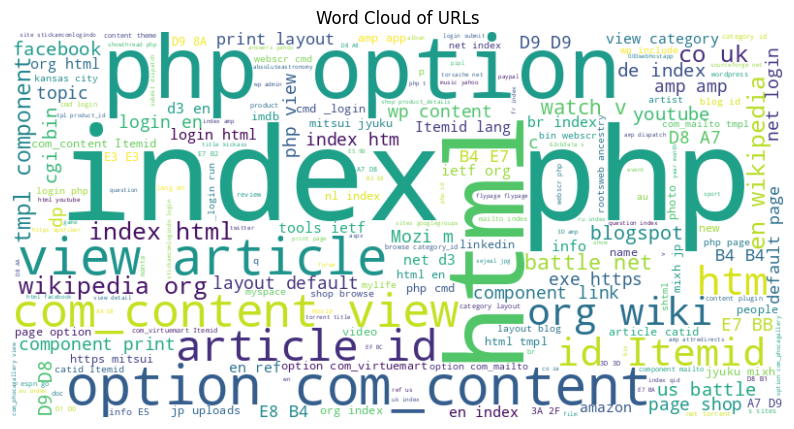

In [45]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['url']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of URLs')
plt.show()

In [46]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Histogram(x=df['url_len'], nbinsx=100))

fig.update_layout(
    title='Distribution of URL Lengths',
    xaxis_title='URL Length',
    yaxis_title='Count',
    template='plotly_dark',
    font=dict(color='white')
)

fig.show()

In [47]:
# Bar chart for 'type' column
type_counts = df['type'].value_counts()
fig = go.Figure(data=[go.Bar(x=type_counts.index, y=type_counts.values)])
fig.update_layout(title='Frequency of URL Types',
                  xaxis_title='URL Type',
                  yaxis_title='Count',
                  template='plotly_dark',
                  font=dict(color='white'),
                  showlegend=False)
fig.show()

In [48]:
# Pie chart for 'url_type' column
url_type_counts = df['url_type'].value_counts()
fig = go.Figure(data=[go.Pie(labels=url_type_counts.index, values=url_type_counts.values)])
fig.update_layout(title='Distribution of URL Types',
                  template='plotly_dark',
                  font=dict(color='white'),
                  showlegend=True)
fig.show()

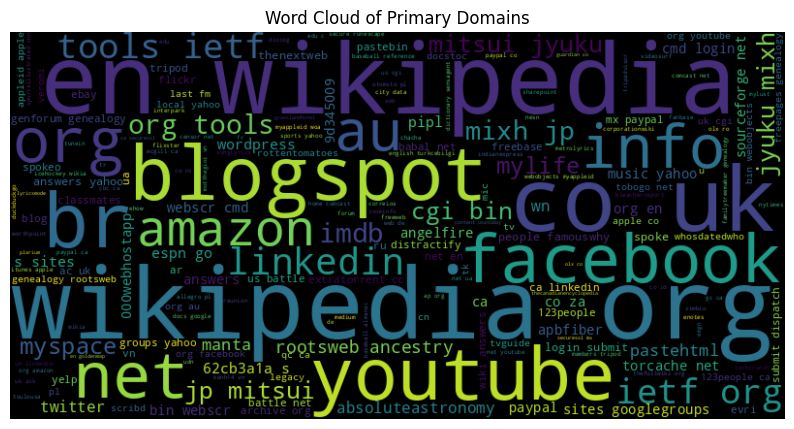

In [49]:
# Convert pri_domain values to strings and filter out None and int values
filtered_domains = df['pri_domain'].map(str).dropna()

# Concatenate all pri_domain values into a single string
text = ' '.join(filtered_domains)

# Generate the WordCloud data
wordcloud = WordCloud(background_color='black', colormap='viridis', width=800, height=400).generate(text)

# Plot the WordCloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Primary Domains', color='black')
plt.show()

In [50]:
counts = df[['letters_count', 'digits_count', 'special_chars_count']].sum()

fig = go.Figure(data=[
    go.Bar(name='Letters', x=['Count'], y=[counts['letters_count']]),
    go.Bar(name='Digits', x=['Count'], y=[counts['digits_count']]),
    go.Bar(name='Special Characters', x=['Count'], y=[counts['special_chars_count']])
])
fig.update_layout(title='Counts of Letters, Digits, and Special Characters',
                  xaxis_title='Type',
                  yaxis_title='Count',
                  barmode='group',
                  template='plotly_dark',
                  font=dict(color='white'))

fig.show()

In [51]:
true_color = 'green'

false_color = 'red'

shortened_counts = df['shortened'].value_counts()
colors = [true_color if val else false_color for val in shortened_counts.index]
fig_shortened = go.Figure(data=go.Bar(x=shortened_counts.index, y=shortened_counts, marker_color=colors))
fig_shortened.update_layout(title='Counts of shortened',
                            xaxis_title='Value',
                            yaxis_title='Count',
                            template='plotly_dark',
                            font=dict(color='white'))
fig_shortened.show()
abnormal_url_counts = df['abnormal_url'].value_counts()
colors = [true_color if val else false_color for val in abnormal_url_counts.index]
fig_abnormal_url = go.Figure(data=go.Bar(x=abnormal_url_counts.index, y=abnormal_url_counts, marker_color=colors))
fig_abnormal_url.update_layout(title='Counts of abnormal_url',
                               xaxis_title='Value',
                               yaxis_title='Count',
                               template='plotly_dark',
                               font=dict(color='white'))
fig_abnormal_url.show()

secure_http_counts = df['secure_http'].value_counts()
colors = [true_color if val else false_color for val in secure_http_counts.index]
fig_secure_http = go.Figure(data=go.Bar(x=secure_http_counts.index, y=secure_http_counts, marker_color=colors))
fig_secure_http.update_layout(title='Counts of secure_http',
                              xaxis_title='Value',
                              yaxis_title='Count',
                              template='plotly_dark',
                              font=dict(color='white'))
fig_secure_http.show()

have_ip_counts = df['have_ip'].value_counts()
colors = [true_color if val else false_color for val in have_ip_counts.index]
fig_have_ip = go.Figure(data=go.Bar(x=have_ip_counts.index, y=have_ip_counts, marker_color=colors))
fig_have_ip.update_layout(title='Counts of have_ip',
                          xaxis_title='Value',
                          yaxis_title='Count',
                          template='plotly_dark',
                          font=dict(color='white'))
fig_have_ip.show()

In [52]:
numeric_data = df.select_dtypes(include='number')

corr_matrix = numeric_data.corr()

heatmap = go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Greys',
)
layout = go.Layout(
    title='Correlation Heatmap (Numeric Values Only)',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Variables'),
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)


fig = go.Figure(data=heatmap, layout=layout)


fig.show()

In [53]:
df.head(7)   # show the first 7 rows of dataset

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,111,buzzfil.net,93,1,24,0,1,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,espn.go.com,31,4,10,0,0,0,0


In [54]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
     ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
     ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
     ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }

    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]

    return "Global"

    # to see region of URL

**Other Features**

In [55]:
df['url_region'] = df['pri_domain'].apply(lambda x: get_url_region(str(x)))

In [56]:
df.head(5)   # show the first 5 rows of dataset

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0,Belgium
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0,Global


In [57]:
region_counts = df['url_region'].value_counts()

if 'Global' not in region_counts.index:
    region_counts['Global'] = 0

data = pd.DataFrame({'region': region_counts.index, 'count': region_counts.values})

colorscale = 'YlOrRd'

fig = go.Figure(data=go.Choropleth(
    locations=data['region'],
    z=data['count'],
    locationmode='country names',
    colorscale=colorscale,
    autocolorscale=True,
    marker_line_color='white',
    colorbar_title='Count'
))
fig.update_layout(title_text='Distribution of URL Regions')

fig.show()

In [58]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

    # extract root domain

In [59]:
df['root_domain'] = df['pri_domain'].apply(lambda x: extract_root_domain(str(x)))

In [60]:
df.head(5)   # show the first 5 rows of dataset

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global,bopsecrets
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [61]:
df.duplicated().sum()

11081

In [63]:
df.drop_duplicates(inplace=True)   # drop duplicates

In [65]:
df.head(5)    # show the first 5 rows of dataset

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global,bopsecrets
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [66]:
data = df.drop(columns=['url','type','pri_domain'])
data.head()

,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,2,16,13,0,3,0,0,0,0,Brazil,br-icloud
1,0,35,29,1,5,0,0,0,0,Global,mp3raid
2,0,31,25,1,5,0,0,0,0,Global,bopsecrets
3,1,77,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,1,228,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [67]:
data['root_domain'].value_counts()

root_domain
wikipedia                  13426
0                          12224
youtube                     8639
blogspot                    8468
facebook                    8362
                           ...  
slipcue                        1
alsholm                        1
internetdownloadmanager        1
jvdgrocerystore                1
xboxaddict                     1
Name: count, Length: 147572, dtype: int64

In [68]:
data = data[data['root_domain'] != '0']

In [69]:
data['root_domain'].value_counts()

root_domain
wikipedia                  13426
youtube                     8639
blogspot                    8468
facebook                    8362
yahoo                       5843
                           ...  
slipcue                        1
alsholm                        1
internetdownloadmanager        1
jvdgrocerystore                1
xboxaddict                     1
Name: count, Length: 147571, dtype: int64

In [70]:
len(data['root_domain'].value_counts())

147571

In [72]:
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

    # for converting numerical values

In [73]:
data['root_domain'] = data['root_domain'].apply(hash_encode)

In [74]:
data['url_region'] = data['url_region'].apply(hash_encode)

In [75]:
data.isnull().sum()

url_type               0
url_len                0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
url_region             0
root_domain            0
dtype: int64

In [76]:
df.columns    # all features

Index(['url', 'type', 'url_type', 'url_len', 'pri_domain', 'letters_count',
       'digits_count', 'special_chars_count', 'shortened', 'abnormal_url',
       'secure_http', 'have_ip', 'url_region', 'root_domain'],
      dtype='object')

In [77]:
x = data.drop(columns=['url_type'])
y = data['url_type']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=42)

**Shapes of test and train features**

In [78]:
print(f"X_train Shape : {x_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {x_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (439520, 10)
Y_train Shape : (439520,)
X_test  Shape : (188366, 10)
Y_test  Shape : (188366,)


**Machine Learning Classifiers**
We are using 6 classifiers for this multi-class problem.  

In [79]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    ExtraTreesClassifier(),
    GaussianNB()
]

In [80]:
results = []
for classifier in classifiers:
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    scores = cross_val_score(pipeline, x, y, cv=2, scoring='accuracy')
    y_pred = cross_val_predict(pipeline, x, y, cv=2)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y, y_pred, average='weighted')
    results.append((classifier.__class__.__name__, accuracy, recall, precision, f1))

**Evaluation Measures ( Accuracy, Recall, Precision, F1-Score)**

In [81]:
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])
results = results.sort_values(by='Accuracy', ascending=False)
results.head()

#  Accuracy: The proportion of correctly classified instances among all instances, indicating overall model correctness.
# Recall (Sensitivity): The proportion of true positives correctly identified, measuring the model's ability to capture positive instances.
# Precision: The proportion of true positives among instances predicted as positive, showing the accuracy of positive predictions.
# F1-Score: The harmonic mean of precision and recall, providing a balanced measure of model performance for imbalanced classes.

,Classifier,Accuracy,Recall,Precision,F1-Score
4,ExtraTreesClassifier,0.805374,0.805374,0.734455,0.763433
1,RandomForestClassifier,0.804253,0.804253,0.733956,0.762742
0,DecisionTreeClassifier,0.798436,0.798436,0.743935,0.766488
2,AdaBoostClassifier,0.786851,0.786851,0.692477,0.732505
3,KNeighborsClassifier,0.785338,0.785338,0.740679,0.756246


In [82]:
pipeline = Pipeline([
        ('classifier', ExtraTreesClassifier())
    ])
pipeline.fit(x_train,y_train)

# Make a pipeline for ExtraTreesClassifier

Pipeline(steps=[('classifier', ExtraTreesClassifier())])

**Evaluation Measures using Pipeline Approach**

In [84]:
y_pred = pipeline.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94    128308
           1       0.92      0.96      0.94     28491
           2       0.69      0.61      0.65     28058
           3       0.88      0.75      0.81      3509

    accuracy                           0.90    188366
   macro avg       0.85      0.82      0.83    188366
weighted avg       0.89      0.90      0.89    188366



**Save pipeline**

In [85]:
import joblib
joblib.dump(pipeline,'eTc.sav')

['eTc.sav']

**Evaluation Measures Visualization**

In [87]:
fig = go.Figure(data=go.Table(
    header=dict(values=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                fill_color='black',
                font=dict(color='white'),
                align='center'),
    cells=dict(values=[results['Classifier'], results['Accuracy'], results['Precision'],
                       results['Recall'], results['F1-Score']],
               fill_color='black',
               font=dict(color='white'),
               align='center')))

fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'))

fig.show()

In [88]:
for column in results.columns:
    fig = go.Figure(data=go.Bar(
        x=results['Classifier'],
        y=results[column],
        marker=dict(color='steelblue'),
        text=results[column],
        textposition='auto'
    ))

    fig.update_layout(
        title_text=column,
        xaxis_title='Model',
        yaxis_title=column,
        plot_bgcolor='rgb(17,17,17)',
        paper_bgcolor='rgb(17,17,17)',
        font=dict(color='white')
    )


    fig.show()

**Predicting URL**

In [90]:
def get_numerical_values(url):
    url = url.replace('www.', '')
    url_len = get_url_length(url)
    letters_count = count_letters(url)
    digits_count  = count_digits(url)
    special_chars_count = count_special_chars(url)
    shortened = has_shortening_service(url)
    abnormal = abnormal_url(url)
    secure_https = secure_http(url)
    have_ip = have_ip_address(url)

    parsed_url  = urlparse(url)
    root_domain = parsed_url.netloc.split(".")[-2]
    url_region = get_url_region(root_domain)

    return {
        'url_len': url_len,
        'letters_count': letters_count,
        'digits_count': digits_count,
        'special_chars_count': special_chars_count,
        'shortened': shortened,
        'abnormal': abnormal,
        'secure_http': secure_https,
        'have_ip': have_ip,
        'url_region': hash_encode(url_region),
        'root_domain': hash_encode(root_domain)
    }

def get_url_length(url):
    return len(url)
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits
def count_special_chars(url):
    special_chars = "!@#$%^&*()_+-=[]{};:,.<>/?`~|"
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars
def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                         r'tr\.im|link\.zip\.net')
    match = pattern.search(url)
    return int(bool(match))
def abnormal_url(url):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname:
        hostname = str(hostname)
        match = re.search(hostname, url)
        if match:
            return 1
    return 0
def secure_http(url):
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 1
    else:
        return 0
def have_ip_address(url):
    pattern = r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' \
              r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|' \
              r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|' \
              r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'

    match = re.search(pattern, url)
    if match:
        return 1
    else:
        return 0
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }

    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]

    return "Global"
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [91]:
def model_predict(url):
    class_mapping = {
        0: 'benign',
        1: 'defacement',
        2: 'phishing',
        3: 'malware'
    }
    numerical_values = get_numerical_values(url)
    prediction_int = pipeline.predict(np.array(list(numerical_values.values())).reshape(1, -1))[0]
    prediction_label = class_mapping.get(prediction_int, 'Unknown')
    return prediction_int, prediction_label

In [97]:
url = "https://www.linedIn.com"
numerical_values = get_numerical_values(url)
print(numerical_values)

{'url_len': 19, 'letters_count': 15, 'digits_count': 0, 'special_chars_count': 4, 'shortened': 0, 'abnormal': 0, 'secure_http': 1, 'have_ip': 0, 'url_region': 32604616, 'root_domain': 24965088}
